# A Movie behind a Script


In [116]:
import os
import re
import pandas as pd
#from datetime import datetime
#import urllib.request
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
# TODO scrape data https://datasets.imdbws.com/
ratings_fn = "title.ratings.tsv.gz"
basics_fn = "title.basics.tsv.gz"

In [4]:
df_ratings = spark.read.option("header", "true")\
                       .option("sep", "\t")\
                       .csv("imdb_data/" + ratings_fn)
df_ratings = df_ratings.selectExpr("tconst", 
                                   "cast(averageRating as float) averageRating", 
                                   "cast(numVotes as int) numVotes")
df_ratings.show()

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1440|
|tt0000002|          6.3|     172|
|tt0000003|          6.6|    1041|
|tt0000004|          6.4|     102|
|tt0000005|          6.2|    1735|
|tt0000006|          5.5|      91|
|tt0000007|          5.5|     579|
|tt0000008|          5.6|    1539|
|tt0000009|          5.6|      74|
|tt0000010|          6.9|    5127|
|tt0000011|          5.4|     214|
|tt0000012|          7.4|    8599|
|tt0000013|          5.7|    1318|
|tt0000014|          7.2|    3739|
|tt0000015|          6.2|     660|
|tt0000016|          5.9|     982|
|tt0000017|          4.8|     197|
|tt0000018|          5.5|     414|
|tt0000019|          6.6|      13|
|tt0000020|          5.1|     232|
+---------+-------------+--------+
only showing top 20 rows



In [5]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

df_basics = spark.read.option("header", "true")\
                      .option("sep", "\t")\
                      .csv("imdb_data/" + basics_fn)
df_basics = df_basics.withColumn("rttmp", df_basics.runtimeMinutes.cast(DoubleType()))\
                     .drop("runtimeMinutes")\
                     .withColumnRenamed("rttmp", "runtimeMinutes")\
                     .withColumn("gtmp", udf_split("genres"))\
                     .drop("genres")\
                     .withColumnRenamed("gtmp", "genres")
df_basics.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|           1.0|[Documentary, Short]|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|           5.0|  [Animation, Short]|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|           4.0|[Animation, Comed...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|          null|  [Animation, Short]|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|           1.0|     [Comedy, 

In [93]:
df_films = spark.read.parquet("parquets/films.parquet")

In [94]:

df_films.show()
df_films.printSchema()

+---------+-------------+----+------+------------------+--------------------+
|   tconst|num_sentences|year|blocks|     subtitle_mins|           subtitles|
+---------+-------------+----+------+------------------+--------------------+
|tt5275892|         6236|2016|  1829|            406.05|[[As, a, kid, gro...|
|tt2234155|         3562|2013|  3348|63.166666666666664|[[An, old, man, t...|
|tt2318527|         7083|2013|  2793| 32.46666666666667|[[BELL, TOLLING],...|
|tt2404463|         4078|2013|  3356| 60.11666666666667|[[Cleaned, correc...|
|tt3311384|         1993|2013|  2116|59.016666666666666|[[CROWD, CHEERING...|
|tt1398426|         3729|2015|  2768| 86.06666666666666|[[Police, Radio, ...|
|tt4540710|         2018|2016|  1668| 67.23333333333333|[[Subtitle, made,...|
|tt4257858|         1553|2015|  2415|              58.8|[[We, will, begin...|
|tt2080374|         2889|2015|  2309|             62.15|[[MAN], [And, wit...|
|tt4425064|         1807|2015|  1951| 68.61666666666666|[[After,

## Data analysis

Here we discuss how we want to proceed with our data.

We consider only films with more than 5,000 reviews as IMDb considers this a good metric to estimate the public actual approval of a film.

We first start by analyzing the 1000 best films according to IMDB with more that 20000 reviews. We look into the resulting dataframe columns and  try to look for some kind of pattern. We look at: 
- the ratio of subtitle time per runtime, 
- the most used words in the films, 
- the ratio of distinct words per total number of words, 
- average sentence length, 
- number of sentences. 

We draw conclusions if we see any apparent relation. Afterwards if we can find a relation between rating and one of the resulting values, we do the same tests on the worst imdb films with more than 20000 reviews.. If we find that a relation holds for both groups we make a statement assuming there exists a relationship

We know this is very vague and we cannot make a strong statement based on what we find, if we find anything because we don't take into consideration many variables such as the movie genre, the year of release, if it is an adult film or not. Also the country of origin is a variable to take into account but we don't have it yet. We can also check the box office for the best films.

To proceed then, we ask what are the most popular genres and we look into how the statistics for the 10 most popular ones behave. Can we find any relationship between a genre and the statistics. We look aswell for relationships between genre and rating. Is the genre of a movie a variable which influences average rating. 

It is all interconnected, we ask ourselves for example, given an action movie, are the value of the statistics influential to its average rating. 

We havent taken TIME into account either! We look into different time periods, particular years where something occured (WW2 end or smth like that) and we try using the same statistics, to find relationships. We need to choose how to address the other variables such as genre and if it is an adult film or not.

After analyzing this data if we find that there are actually dependencies between the values, we decide to create a small learning algorithm to predict the rating of a film given its script.

In [16]:
def word_statistics(df_films):
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))
    df_basics 
    
    df_word_counts = df_words.groupby("tconst", "num_subtitles", "blocks", "subtitle_mins")\
                             .agg(psf.count("word").alias("Number of words"), 
                                  psf.countDistinct("word").alias("Number of distinct words"))\
                             .withColumn("Mean length of sentences",
                                         psf.col("Number of words") / psf.col("num_subtitles"))\
                             .withColumn("Spread of sentences",
                                         psf.col("num_subtitles") / psf.col("blocks"))\
                             .withColumn("Spread of sentences",
                                         psf.col("num_subtitles") / psf.col("blocks"))\
                             .join(df_basics, ['tconst'], 'left_outer')\
                             .withColumn("Runtime to Subtitles minutes",
                                         psf.col("subtitle_mins")/ psf.col("runtimeMinutes"))
#                             .select(df_word_counts['*'], 
#                                      (df_basics['runtimeMinutes'] / df_word_counts['subtitle_mins'])\
#                                      .alias("Runtime to Subtitles minutes"))
    
    return df_word_counts

In [34]:
df_word_stats = word_statistics(df_films)
#df_word_stats.show()

## Scatter plots

In [35]:
df_words_ratings = df_word_stats.join(df_ratings, "tconst")
#df_words_ratings.show()

In [36]:
df_words_ratings_pd = df_words_ratings.toPandas()

Using the resulting dataframe we first look at it statistics for each entry. And then we plot each column vs the average rating to see if we find some kind of linear dependency. We also plot the histograms of each metric for films we consider "good" and films we consider "bad" to see if we have different distributions for such metrics.

In [37]:
print("Means:")
print(df_words_ratings_pd.mean(), "\n")
print("Medians:")
print(df_words_ratings_pd.median(), "\n")
print("Std deviations")
print(df_words_ratings_pd.std())

Means:
num_subtitles                    1459.899649
blocks                           1104.920936
subtitle_mins                      44.808675
Number of words                  7627.643041
Number of distinct words         1507.922807
Mean length of sentences            5.290307
Spread of sentences                 1.461879
runtimeMinutes                    108.877193
Runtime to Subtitles minutes        0.391332
averageRating                       6.683205
numVotes                        54557.711813
dtype: float64 

Medians:
num_subtitles                    1401.000000
blocks                           1064.000000
subtitle_mins                      39.433333
Number of words                  7252.000000
Number of distinct words         1497.000000
Mean length of sentences            5.103940
Spread of sentences                 1.253968
runtimeMinutes                    104.000000
Runtime to Subtitles minutes        0.379167
averageRating                       6.800000
numVotes              

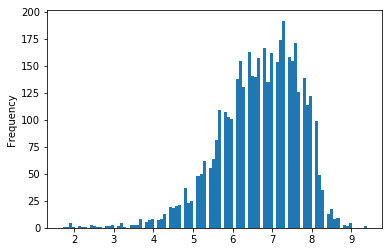

In [31]:
df_words_ratings_pd["averageRating"].plot.hist(bins=100)

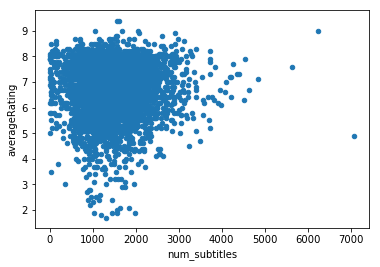

In [18]:
ax = df_words_ratings_pd.plot.scatter("num_subtitles", "averageRating")

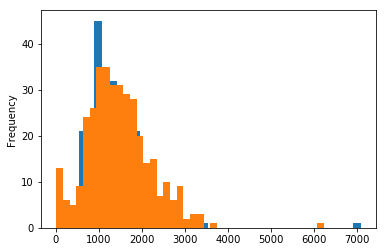

In [48]:
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["num_subtitles"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["num_subtitles"].plot.hist(bins=40)

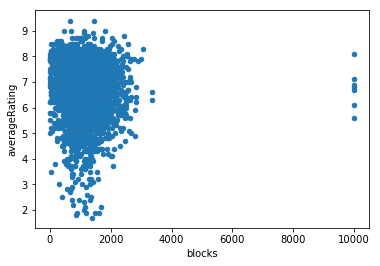

In [28]:
ax = df_words_ratings_pd.plot.scatter("blocks", "averageRating")

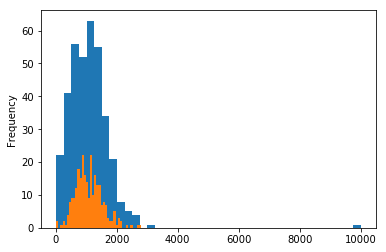

In [53]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["blocks"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["blocks"].plot.hist(bins=40)

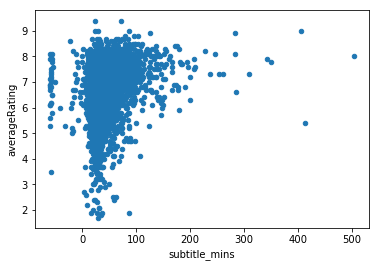

In [29]:
ax = df_words_ratings_pd.plot.scatter("subtitle_mins", "averageRating")

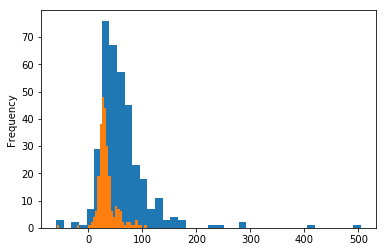

In [52]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["subtitle_mins"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["subtitle_mins"].plot.hist(bins=40)

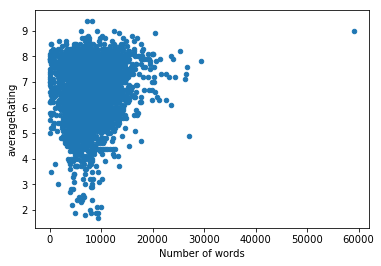

In [30]:
ax = df_words_ratings_pd.plot.scatter("Number of words", "averageRating")

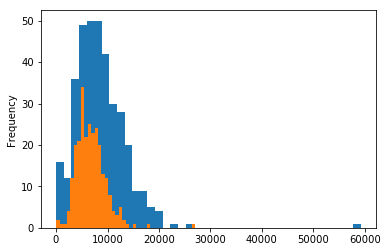

In [51]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["Number of words"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["Number of words"].plot.hist(bins=40)
plt.show()

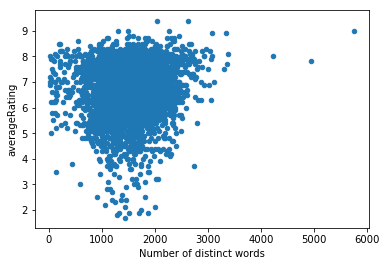

In [31]:
ax = df_words_ratings_pd.plot.scatter("Number of distinct words", "averageRating")

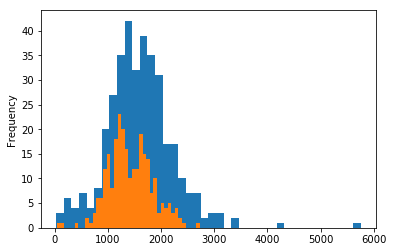

In [50]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["Number of distinct words"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["Number of distinct words"].plot.hist(bins=40)

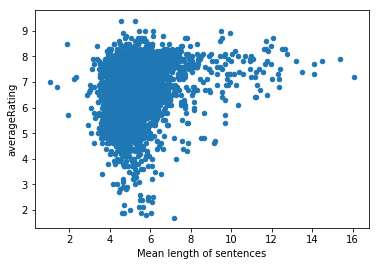

In [32]:
ax = df_words_ratings_pd.plot.scatter("Mean length of sentences", "averageRating")

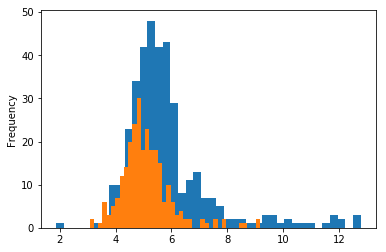

In [54]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["Mean length of sentences"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["Mean length of sentences"].plot.hist(bins=40)

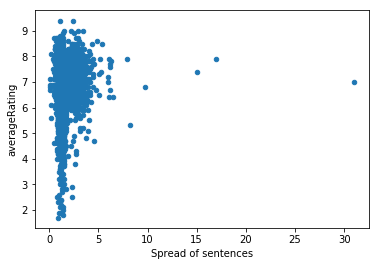

In [33]:
ax = df_words_ratings_pd.plot.scatter("Spread of sentences", "averageRating")

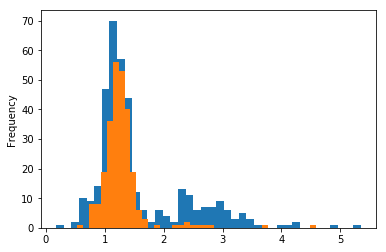

In [56]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["Spread of sentences"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["Spread of sentences"].plot.hist(bins=40)

These plots show us little relation between the found metrics and the actual film rating, the only thing we could state is that films with more text tend to be better rated. We now look at the different genres.


In [45]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", "genres", "primaryTitle", "runtimeMinutes"), ["tconst"])
df_genres= df_genres.join(df_ratings, ["tconst"])

Here we find the average rating for the 10 most represented genres.

In [70]:
df_genres_avRating = df_genres.select('*', psf.explode('genres').alias('genre')).groupBy("genre").agg({"averageRating": "mean", "*": "count"})
df_genres_rating_pd = df_genres_avRating.sort("count(1)", ascending=False).limit(10).toPandas()

We can see that there are no very big differences between genres apparently, though we can see that a Drama movie is more likely to have a good rating than a horror movie. From these statistics we could assume that the genre has somehow an influence in the film's average rating.

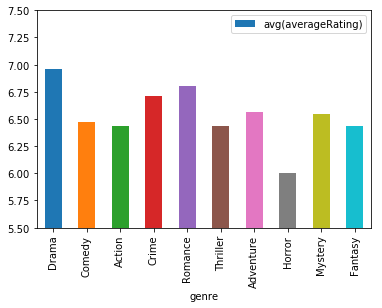

In [81]:
df_genres_rating_pd.plot.bar(y="avg(averageRating)", x="genre")
plt.ylim(5.5, 7.5)
plt.show()

In [92]:
def add_time_period(year):
    if year < 1910 or year > 2018:
        return "NaN"
    elif year < 1960:
        return "1910-1950's"
    elif year < 2000:
        return "1960-1990's"
    else:
        return "2000's"
udf_period = psf.udf(add_time_period, StringType())    

In [99]:
df_all = spark.read.parquet("parquets/words/allwords.parquet/")
df_film_words = spark.read.parquet("parquets/words/filmwords.parquet/")
df_all.sort("count", ascending=False).show()
df_film_words.sort("count", ascending=False).show()


+----+-------+
|word|  count|
+----+-------+
|   I|1304701|
| you|1074551|
| the| 906553|
|  to| 746516|
|   a| 626537|
|  it| 457048|
|  of| 382511|
|that| 363364|
| You| 361943|
| and| 344160|
|  in| 319820|
|  me| 318220|
|  is| 314460|
|  on| 230377|
| for| 219431|
|this| 209579|
|your| 202776|
|have| 201724|
|  my| 200440|
|What| 198087|
+----+-------+
only showing top 20 rows

+---------+----+-----+
|   tconst|word|count|
+---------+----+-----+
|tt5275892| the| 2380|
|tt5275892|   I| 2040|
|tt5275892|  to| 1519|
|tt0048977|   I| 1424|
|tt5275892|   a| 1343|
|tt0829482|   I| 1328|
|tt0064117|   I| 1320|
|tt0380268| the| 1295|
|tt5275892| and| 1224|
|tt5275892| was| 1224|
|tt0101912|   I| 1202|
|tt5275892|that| 1199|
|tt0031381|   I| 1180|
|tt0052415|   I| 1172|
|tt0102138| the| 1129|
|tt2318527| YOU| 1124|
|tt0478311|   I| 1115|
|tt5275892|  of| 1106|
|tt0031381| you| 1088|
|tt0058461| the| 1079|
+---------+----+-----+
only showing top 20 rows



In [117]:
stopwords = set(stopwords.words('english'))
df_film_words.filter(~psf.lower(df_film_words.word).isin(stopwords)).sort("count", ascending=False).show()
df_all.filter(~psf.lower(df_all.word).isin(stopwords)).sort("count", ascending=False).show()

+---------+--------+-----+
|   tconst|    word|count|
+---------+--------+-----+
|tt1777034|cHFFFFFF| 1055|
|tt0116126|   MUSIC|  716|
|tt2304933|     igt|  706|
|tt3327994|       J|  547|
|tt0211181|   music|  506|
|tt0056264|     sir|  496|
|tt2318527|      OH|  424|
|tt0405393|       u|  388|
|tt0100405|   Music|  351|
|tt0038969|   Remus|  346|
|tt3327994|       r|  345|
|tt0410097|     man|  327|
|tt5275892|    know|  327|
|tt0049233|    thee|  318|
|tt3317522|    LIKE|  304|
|tt2318527|    YEAH|  297|
|tt0115678|       e|  295|
|tt5275892| Simpson|  275|
|tt0048977|      Oh|  270|
|tt2671706|     got|  268|
+---------+--------+-----+
only showing top 20 rows

+-----+------+
| word| count|
+-----+------+
| know|184207|
| like|128187|
|  get|120413|
|   go|117571|
|right|114061|
|   Oh|101837|
|  got| 97525|
|  one| 91485|
| want| 90749|
| Yeah| 84464|
|think| 81825|
|  see| 77025|
|going| 69965|
|  Yes| 69698|
| Come| 66486|
| Well| 65297|
| back| 64903|
|   us| 62987|
| time| 628